# Price Prediction using Linear Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import Data_cleaning as t

raw_listings = pd.read_csv('data/listings.csv')

In [ ]:
listings = t.clean_dataset(raw_listings)

## One-hot encoding

In [39]:
# Dropping initial and intermidiate columns
listings = listings.drop(review_cols, axis=1)
listings = listings.drop(columns=['last_review', 
                                  'days_since_last_review', 'days_since_first_review', 
                                  'first_review', 'last_scraped', 'amenities', 'host_since', 'host_listings_count'])

# Include all object and category columns
cat_columns = listings.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:    
    listings = pd.concat([listings.drop(col, axis=1), pd.get_dummies(listings[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)    

In [40]:
listings_no_host_i = listings

## Fitting the model

In [79]:
#Split into explanatory and response variables
X = listings.drop('price', axis=1)
y = listings['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)
test_rmse = mean_squared_error(y_test, y_test_preds) ** (1/2)
train_rmse = mean_squared_error(y_train, y_train_preds) ** (1/2)

test_mae = mean_absolute_error(y_test, y_test_preds)
train_mae = mean_absolute_error(y_train, y_train_preds)

print("""
        R2 for test data: {}
        R2 for test data: {}
        
        RMSE for test data: {}
        RMSE for train data: {}
        
        Mean Absolute Error for test data: {}
        Mean Absolute Error for train data: {}
    """.format(test_r2, train_r2, test_rmse, train_rmse, test_mae, train_mae)
     )




        R2 for test data: 0.5648173924697604
        R2 for test data: 0.5697177700349588
        
        RMSE for test data: 45.1628223109022
        RMSE for train data: 45.078865254683656
        
        Mean Absolute Error for test data: 29.258549166825635
        Mean Absolute Error for train data: 29.658711814378528
    


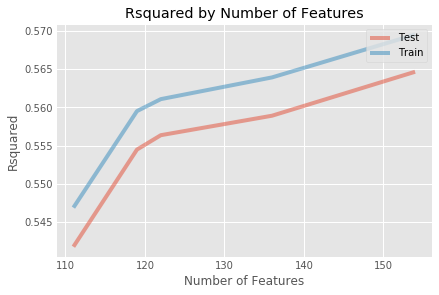

In [42]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
        
    plt.style.use('ggplot')
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs, plot=True)

In [81]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['feature'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('feature', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(10)

,feature,coefs,abs_coefs
122,room_type_Shared room,-45.296278,45.296278
121,room_type_Private room,-26.354726,26.354726
120,room_type_Hotel room,6.003149,6.003149
27,reviews_per_month,-1.240177,1.240177
151,review_scores_value_cats_No reviews,-17.411866,17.411866
150,review_scores_value_cats_9/10,-0.183808,0.183808
149,review_scores_value_cats_10/10,-5.896097,5.896097
154,review_scores_rating_cat_No reviews,8.069598,8.069598
153,review_scores_rating_cat_95-100/100,5.028186,5.028186
152,review_scores_rating_cat_80-94/100,-1.053832,1.053832


# Price Prediction using XGBoost


In [83]:
import xgboost
from xgboost import plot_importance

#Instantiate
xgb_model = xgboost.XGBRegressor()
#Fit
xgb_model.fit(X_train, y_train)
#Predict
training_preds_xgb_reg = xgb_model.predict(X_train)
test_preds_xgb_reg = xgb_model.predict(X_test)


print("""
        Training RMSE: {}
        Test RMSE: {}
        
        Training R2: {}
        Test R2: {}
        
        Training Mean Absolute Error: {}
        Test Mean Absolute Error: {}
    """.format(mean_squared_error(y_train, training_preds_xgb_reg) ** (1/2),
               mean_squared_error(y_test, test_preds_xgb_reg) ** (1/2),
               r2_score(y_train, training_preds_xgb_reg),
               r2_score(y_test, test_preds_xgb_reg),
               mean_absolute_error(y_train, training_preds_xgb_reg),
               mean_absolute_error(y_test, test_preds_xgb_reg)
              )
     )




        Training RMSE: 30.82521036434503
        Test RMSE: 38.619985695474064
        
        Training R2: 0.7988038998561844
        Test R2: 0.6817755099212873
        
        Training Mean Absolute Error: 20.557898598877955
        Test Mean Absolute Error: 24.601560799028498
    


## Feature importance

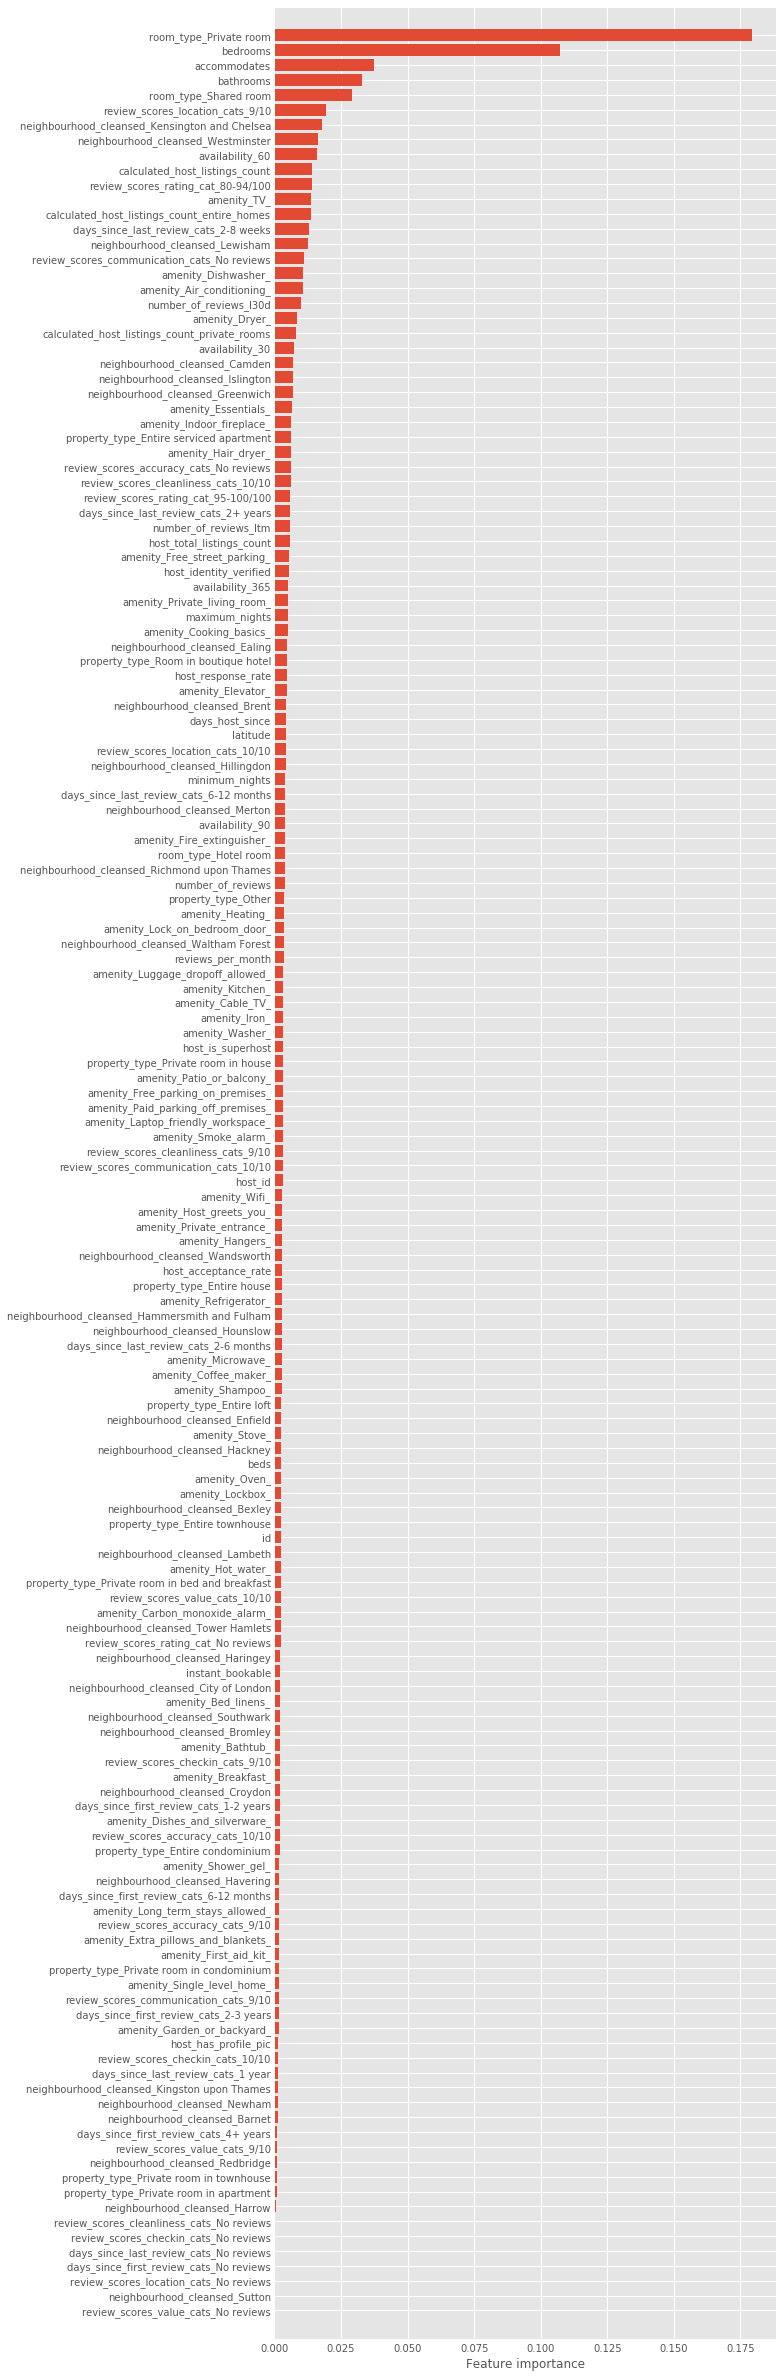

,weight
room_type_Private room,0.179256
bedrooms,0.107256
accommodates,0.037506
bathrooms,0.032869
room_type_Shared room,0.029065
review_scores_location_cats_9/10,0.019483
neighbourhood_cleansed_Kensington and Chelsea,0.017864
neighbourhood_cleansed_Westminster,0.016419
availability_60,0.016147
calculated_host_listings_count,0.014076


In [48]:
ft_weights_xgb_reg = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg = ft_weights_xgb_reg.sort_values('weight')

# Plotting feature importances
plt.figure(figsize=(8, 40))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()
ft_weights_xgb_reg.sort_values(by='weight', ascending=False)[:10]